# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Image Pipeline

Import the python file containing object tracking pipeline. This file contains all of the classes and helper functions. All parameter choices are made in this document.

In [1]:
%run car_tracking.py

## The Car Classifier

The first step in the pipeline is to train a car classifier that is then used to identify cars in the subsequent sliding window search.

The feature set for the classifier consists of a histogram of oriented gradients (HOG), which essentially describes the shape of an image in a reduced feature space, by extracting the dominant gradient direction in so-called pixel cells which subdivide the image. In addition to the gradients, eac cell's color histogram is also recorded and used as a training feature.

### Histogram of Oriented Gradients (HOG)

The HOG is extracted from the lightness channel within the ImageFrame object which is in the HLS colour space. This ImageFrame object contains all of the information related to the current image or video frame of interest, including the HOG features and cell color histograms.

To improve the performance of the sliding window search, the HOG features are extracted once and then used for all queries. The size of the cell is already defined above.

In [2]:
cell_size = 8 #px
hog_params = {'orientations': 8,
              'pix_per_cell': cell_size,
              'cell_per_block': 2,
              'visualise': True}
area_of_interest_training_image = ((0, 0), (1, 1))

frame = ImageFrame(area_of_interest_training_image, hog_params)

When the image frame object is fed with an image, it automatically converts the image to the HLS colour space (from RGB) and computes the HOG features: 

In [3]:
preview = import_image('./test_images/image0120.png')
frame(preview)

/Users/MarkDekker15/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Visualise the result of the HOG feature extraction:

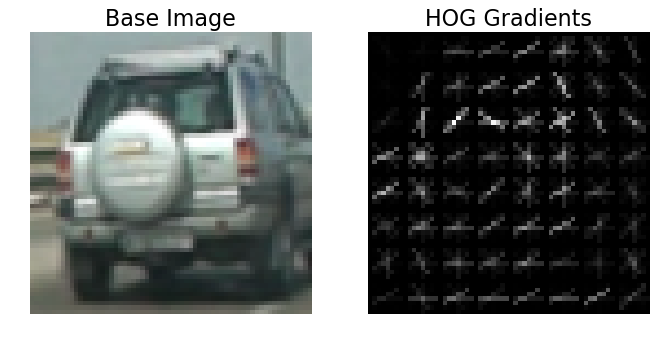

In [4]:
base_image = frame.get_area_of_interest()
base_image = cv2.cvtColor(base_image, cv2.COLOR_HLS2RGB)

compare_images(base_image, frame.get_hog_visualisation(), ('Base Image', 'HOG Gradients'))

### Colour Histograms

For the colour features, the image is resized to a coarse representation and then each pixel channel (in the HLS colour space) is split into bins. This decision was made because it was felt that hue and saturation values are more distict for vehicles than red, green and blue intensities.

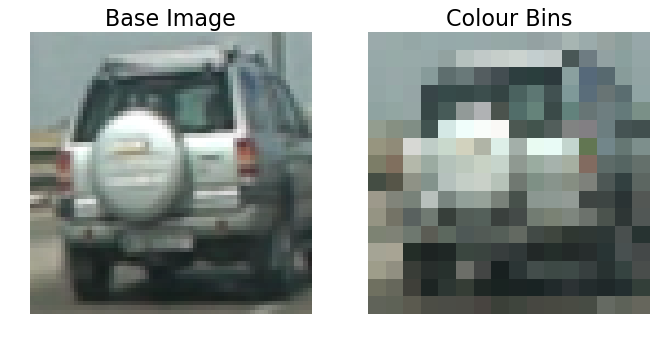

In [5]:
compare_images(base_image, frame.get_colour_bin_visualisation(), ('Base Image', 'Colour Bins'))

### Training the Classifier

In [13]:
%run car_tracking.py

Import the training data.

In [14]:
training_set = TrainingData('./training_data/')

Training data set imported.


A sample of the training images labeled as vehicles:

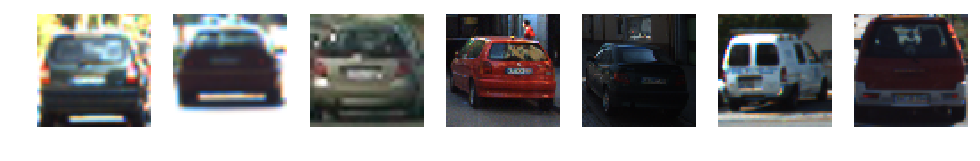

In [15]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

A sample of the training images labeled as non-vehicles:

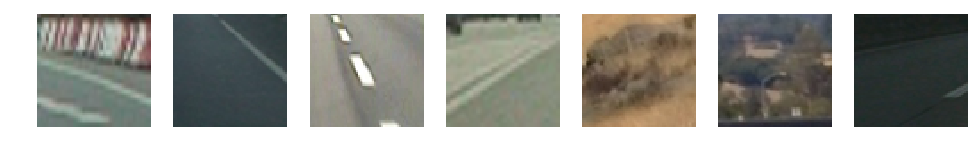

In [16]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='non-vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

Extract the desired training features from the data set. For this, the training set object makes use of an ImageFrame object to extract the features as seen above.

In [ ]:
training_set.extract_features(frame)

/Users/MarkDekker15/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extracted feature vectors from images labelled as non-vehicles in 99.54121804237366 sec.


Get training and test set:

Normalising the features during training:

Run fit the classifier to the training data:

Test the classifier accuracy:

## Sliding Window Search

Set the region of interest in the input video file:

In [ ]:
top = 380/720
bottom = 720/720
left = 0/1280
right = 1280/1280

area_of_interest = ((left, top), (right, bottom))

preview = import_image('./test_images/test1.jpg')
plot_image(quick_rectangle(preview, area_of_interest, filled=True))

Downsample (reduce the image resolution) to improve the computational performance:

In [ ]:
downsampling_factor = 1 #Higher values lead to lower resolutions 

Set the sliding window parameters and the portions of the area of interest where the sliding window search should be conducted for each respective window size. The units for the search windows are in cells.

In [ ]:
search_windows = {'small': {'size': (10, 10),
                            'step_y': 5,
                            'step_x': 5,
                            'search_area': 'far'},
                  'medium': {'size': (20, 20),
                             'step_y': 10,
                             'step_x': 10,
                             'search_area': 'medium'},
                  'large': {'size': (40, 40),
                            'step_y': 20,
                            'step_x': 20,
                            'search_area': 'all'}}

Define the previously mentioned search areas as rectangles covering the area of interest.  The coordinates are given as fractions relative to the bounding box of the area of interest:

In [ ]:
search_areas = {'all': ((0, 0), (1.0, 1.0)),
                'medium': ((0, 0.3), (1.0, 0.7)),
                'far': ((0, 0), (1.0, 0.4))}

Obtain a grid search object from these parameters, that can then be used to search the input images.

In [ ]:
searcher = GridSearch(search_windows, search_areas)

# Processing Video

## Filtering False Positives and Duplicate Matches